In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

In [2]:
def read_image(image_path):
    """Reads and returns image."""
    return mpimg.imread(image_path)

def read_image_and_print_dims(image_path):
    """Reads and returns image.
    Helper function to examine how an image is represented.
    """
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

In [5]:
# Read and save test images to array
test_images = [read_image('data_copy/test_images/' + i) for i in os.listdir('data_copy/test_images')]

In [37]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    # print("Hough lines: ", lines)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [38]:

def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, 
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)

In [39]:
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

In [40]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
    # If either array is empty, waive length requirement
    if not positive_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_points.append([x1, y1])
                    positive_slope_points.append([x2, y2])
                    positive_slope_intercept.append([slope, y1-slope*x1])
    if not negative_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_points.append([x1, y1])
                    negative_slope_points.append([x2, y2])
                    negative_slope_intercept.append([slope, y1-slope*x1])
    if not positive_slope_points:
        print("positive_slope_points still empty")
    if not negative_slope_points:
        print("negative_slope_points still empty")
    # Even though positive_slope_points is not used, I am keeping it for debugging purposes.
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)
    # print("Positive slope line points: ", positive_slope_points)
    # print("Negative slope line points: ", negative_slope_points)
    # print("positive slope points dtype: ", positive_slope_points.dtype)

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    
    # Discarded Linear Regression Option:
    # Get intercept and coefficient of linear regression lines
    # pos_coef, pos_intercept = find_linear_regression_line(positive_slope_points)
    # neg_coef, neg_intercept = find_linear_regression_line(negative_slope_points)
    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)

In [41]:
from sklearn.linear_model import LinearRegression

def find_linear_regression_line(points):
    # Separate points into X and y to fit LinearRegression model
    points_x = [[point[0]] for point in points]
    points_y = [point[1] for point in points]
    # points_x_print = [point[0] for point in points]
    # print("X points: ", points_x, "Length: ", len(points_x))
    # print("X points: ", points_x_print, "Length: ", len(points_x))
    # print("Y points: ", points_y, "Length: ", len(points_y))

    # Fit points to LinearRegression line
    clf = LinearRegression().fit(points_x, points_y)

    # Get parameters from line
    coef = clf.coef_[0]
    intercept = clf.intercept_
    print("Coefficients: ", coef, "Intercept: ", intercept)
    return coef, intercept

In [42]:
import os
os.listdir("data_copy/test_images")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

Pipeline
Steps:


1. Read in and grayscale the image

2. Define a kernel size and apply Gaussian smoothing

3. Define our parameters for Canny and apply to get edges image

4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)

5. Define Hough transform parameters and run Hough transform on masked edge-detected image

6. Draw line segments

7. Draw lines extrapolated from line segments

8. Combine line image with original image to see how accurate the line annotations are.

In [43]:
def draw_lane_lines(image):
    """Draw lane lines in white on original image."""
    # Print image details
    # print("image.shape: ", image.shape)
    imshape = image.shape
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    plt.subplot(2,2,1)
    plt.imshow(greyscaled_image, cmap="gray")
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    
    # Mask edges image
    border = 0
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)
    ## Plot masked edges image
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    plt.subplot(2,2,2)
    plt.imshow(bw_edges_image_with_mask)
    
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Convert Hough from single channel to RGB to prep for weighted
    # TODO: Have it convert the lines to red, not white.
    hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
    # hough_rgb_image.dtype: uint8.  Shape: (540,960,3).
    # hough_rgb_image is like [[[0 0 0], [0 0 0],...] [[0 0 0], [0 0 0],...]]
    ## Plot Hough lines image
    plt.subplot(2,2,3)
    plt.imshow(hough_rgb_image)    
    
    # Combine lines image with original image
    final_image = weighted_img(hough_rgb_image, image)
    ## Plot final image
    plt.subplot(2,2,4)
    plt.imshow(final_image)
    return final_image

Slope & intercept:  [[0.5606060606060606, 48.121212121212125], [0.5777777777777777, 43.44444444444446]]
Slope:  0.5691919191919191 Intercept:  45.78282828282829
Slope & intercept:  [[-0.7009966777408638, 645.953488372093], [-0.7554744525547445, 671.2080291970804], [-0.7777777777777778, 681.7777777777778], [-0.7784431137724551, 678.9700598802395], [-0.8333333333333334, 700.6666666666667], [-0.7474747474747475, 668.060606060606], [-0.7578947368421053, 667.7789473684211]]
Slope:  -0.7750663602925273 Intercept:  678.0770144917985
Coef:  0.5691919191919191 Intercept:  45.78282828282829 intersection_x:  470.36659238689566
Point one:  (470, 313) Point two:  (960, 592)
Coef:  -0.7750663602925273 Intercept:  678.0770144917985 intersection_x:  470.36659238689566
Point one:  (470, 313) Point two:  (0, 678)


array([[[ 82, 125, 162],
        [ 82, 125, 162],
        [ 82, 125, 162],
        ...,
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 125, 160],
        [ 82, 125, 160],
        [ 82, 125, 160],
        ...,
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 126, 158],
        [ 82, 126, 158],
        [ 82, 126, 158],
        ...,
        [ 78, 122, 157],
        [ 77, 120, 155],
        [ 72, 115, 150]],

       ...,

       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ...,
        [ 58,  63,  74],
        [ 58,  63,  74],
        [ 58,  63,  74]],

       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ...,
        [ 57,  62,  73],
        [ 57,  62,  73],
        [ 57,  62,  73]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ...,
        [ 58,  62,  71],
        [ 58,  62,  71],
        [ 58,  62,  71]]

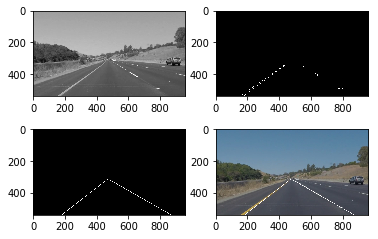

In [44]:
draw_lane_lines(test_images[0])

Slope & intercept:  [[0.6490384615384616, -4.8125], [0.5970873786407767, 22.883495145631116], [0.5786516853932584, 36.915730337078685]]
Slope:  0.6082591751908323 Intercept:  18.3289084942366
Slope & intercept:  [[-0.6743421052631579, 631.0592105263158], [-0.7246963562753036, 653.9676113360324], [-0.6888888888888889, 634.6444444444444], [-0.726027397260274, 653.7123287671233], [-0.6741935483870968, 630.7129032258065]]
Slope:  -0.6976296592149442 Intercept:  640.8192996599444
Coef:  0.6082591751908323 Intercept:  18.3289084942366 intersection_x:  476.6794651774183
Point one:  (476, 308) Point two:  (960, 602)
Coef:  -0.6976296592149442 Intercept:  640.8192996599444 intersection_x:  476.6794651774183
Point one:  (476, 308) Point two:  (0, 640)


array([[[147, 157, 168],
        [115, 127, 142],
        [106, 123, 142],
        ...,
        [102, 122, 141],
        [112, 129, 142],
        [146, 159, 171]],

       [[114, 126, 142],
        [115, 130, 147],
        [106, 125, 146],
        ...,
        [ 99, 123, 144],
        [110, 127, 144],
        [113, 128, 142]],

       [[105, 122, 141],
        [106, 125, 146],
        [100, 123, 147],
        ...,
        [ 94, 120, 145],
        [ 98, 120, 142],
        [100, 121, 139]],

       ...,

       [[103, 102, 107],
        [ 92,  91,  96],
        [ 88,  87,  92],
        ...,
        [ 66,  66,  74],
        [ 70,  70,  78],
        [ 95,  95, 103]],

       [[113, 112, 116],
        [100,  99, 103],
        [ 92,  91,  95],
        ...,
        [ 70,  70,  78],
        [ 85,  85,  91],
        [109, 109, 115]],

       [[141, 140, 144],
        [111, 110, 114],
        [102, 102, 106],
        ...,
        [ 95,  95, 102],
        [110, 110, 116],
        [146, 146, 153]]

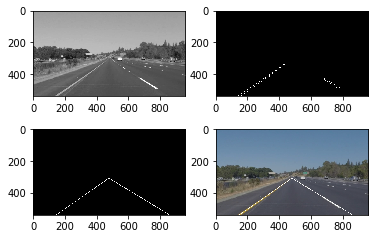

In [16]:
draw_lane_lines(test_images[1])

Slope & intercept:  [[0.6026490066225165, 25.145695364238406], [0.5770491803278689, 34.659016393442585], [0.5777027027027027, 32.5101351351351], [0.5588235294117647, 47.91176470588232]]
Slope:  0.5711918041474454 Intercept:  38.36030541148667
Slope & intercept:  [[-0.7263513513513513, 655.2162162162163], [-0.7542372881355932, 671.9491525423729], [-0.7444444444444445, 658.0222222222222], [-0.7570093457943925, 673.5046728971963], [-0.7457627118644068, 657.3220338983051], [-0.6794871794871795, 640.2564102564103]]
Slope:  -0.7455610283180375 Intercept:  663.2028595552626
Coef:  0.5711918041474454 Intercept:  38.36030541148667 intersection_x:  474.53291060997617
Point one:  (474, 309) Point two:  (960, 586)
Coef:  -0.7455610283180375 Intercept:  663.2028595552626 intersection_x:  474.53291060997617
Point one:  (474, 309) Point two:  (0, 663)


array([[[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ...,
        [ 78, 125, 160],
        [ 76, 123, 158],
        [ 74, 122, 157]],

       [[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ...,
        [ 77, 124, 159],
        [ 75, 122, 158],
        [ 72, 121, 156]],

       [[ 82, 126, 161],
        [ 83, 126, 162],
        [ 82, 127, 162],
        ...,
        [ 75, 124, 159],
        [ 74, 122, 158],
        [ 72, 121, 156]],

       ...,

       [[ 82,  82,  88],
        [ 82,  82,  88],
        [ 82,  82,  88],
        ...,
        [ 62,  66,  74],
        [ 62,  66,  74],
        [ 62,  66,  74]],

       [[ 82,  81,  87],
        [ 82,  81,  87],
        [ 82,  81,  87],
        ...,
        [ 62,  66,  73],
        [ 62,  65,  72],
        [ 62,  65,  72]],

       [[ 79,  78,  85],
        [ 79,  78,  85],
        [ 79,  78,  85],
        ...,
        [ 62,  65,  72],
        [ 62,  65,  72],
        [ 62,  65,  72]]

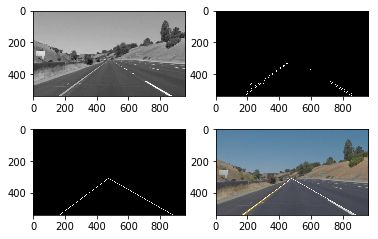

In [17]:
draw_lane_lines(test_images[2])

Slope & intercept:  [[0.6214285714285714, 7.921428571428578], [0.6512455516014235, -4.185053380782904], [0.6507177033492823, -4.545454545454504]]
Slope:  0.6411306087930924 Intercept:  -0.26969311826961
Slope & intercept:  [[-0.6713286713286714, 630.1118881118881], [-0.7222222222222222, 655.8333333333334], [-0.6733333333333333, 631.7333333333333], [-0.6973684210526315, 646.7631578947369]]
Slope:  -0.6910631619842146 Intercept:  641.1104281683229
Coef:  0.6411306087930924 Intercept:  -0.26969311826961 intersection_x:  481.4465698277216
Point one:  (481, 308) Point two:  (960, 615)
Coef:  -0.6910631619842146 Intercept:  641.1104281683229 intersection_x:  481.4465698277216
Point one:  (481, 308) Point two:  (0, 641)


array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ...,
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ...,
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ...,
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ...,

       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ...,
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ...,
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ...,
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144, 146]]

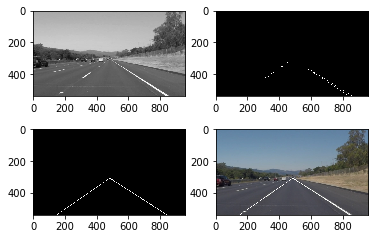

In [18]:
draw_lane_lines(test_images[3])

Slope & intercept:  [[0.5986622073578596, 22.35451505016721], [0.5741444866920152, 32.08745247148289], [0.5782608695652174, 28.39565217391305], [0.6014234875444839, 18.971530249110344]]
Slope:  0.5881227627898941 Intercept:  25.452287486168373
Slope & intercept:  [[-0.7525773195876289, 671.4536082474226], [-0.7813620071684588, 689.584229390681], [-0.748792270531401, 671.1835748792271], [-0.765625, 686.734375], [-0.8, 697.6], [-0.8070175438596491, 696.3684210526316], [-0.8222222222222222, 709.2666666666667], [-0.8333333333333334, 707.0]]
Slope:  -0.7888662120878367 Intercept:  691.1488594045786
Coef:  0.5881227627898941 Intercept:  25.452287486168373 intersection_x:  483.4436470179585
Point one:  (483, 309) Point two:  (960, 590)
Coef:  -0.7888662120878367 Intercept:  691.1488594045786 intersection_x:  483.4436470179585
Point one:  (483, 309) Point two:  (0, 691)


array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ...,
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ...,
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ...,
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ...,

       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ...,
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ...,
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ...,
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,  75]]

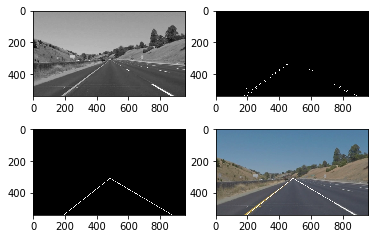

In [19]:
draw_lane_lines(test_images[4])

Slope & intercept:  [[0.5535055350553506, 41.50553505535049], [0.5748299319727891, 33.874149659863974], [0.5774058577405857, 31.3305439330544], [0.5528455284552846, 41.097560975609724]]
Slope:  0.5646467133060025 Intercept:  36.95194740596965
Slope & intercept:  [[-0.8106508875739645, 698.7100591715977], [-0.7555555555555555, 671.5555555555555], [-0.7054263565891473, 653.6744186046512], [-0.7833333333333333, 688.6]]
Slope:  -0.7637415332630001 Intercept:  678.1350083329511
Coef:  0.5646467133060025 Intercept:  36.95194740596965 intersection_x:  482.67745712373363
Point one:  (482, 309) Point two:  (960, 579)
Coef:  -0.7637415332630001 Intercept:  678.1350083329511 intersection_x:  482.67745712373363
Point one:  (482, 309) Point two:  (0, 678)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ...,

       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ...,
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ...,
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ...,
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,  70]]

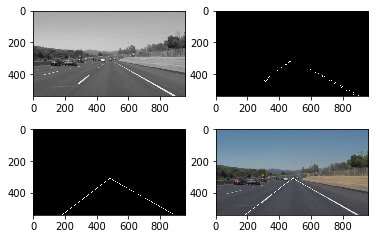

In [20]:
draw_lane_lines(test_images[5])

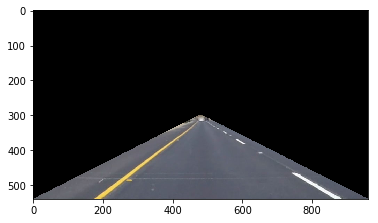

In [27]:
# Debugging mask
border = 80
imshape = [540, 960]
vertices = np.array([[(0,imshape[0]),(475, 300), (485, 300), 
                      (imshape[1],imshape[0])]], 
                    dtype=np.int32)    
plt.imshow(region_of_interest(test_images[4], vertices))